# Exercise 2

## Question 1

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from particles import distributions as dists
from particles import mcmc
from particles import state_space_models as ssm
import pandas as pd

# Assuming the dataset file is named 'youtube.csv' and located in the same directory as this script
youtube_data = pd.read_csv('youtube.csv')

# Load the dataset
# youtube_data = pd.read_csv('youtube.csv')  # Adjust path as necessary

# Normalize the data
scale_factor = 1e6  # Scaling factor to normalize data
youtube_data['Normalized users'] = youtube_data['Monthly active users'] / scale_factor
# Display the first few rows of the dataset to verify
print(youtube_data.head())


   Year  Monthly active users  Normalized users
0  2005               1946322          1.946322
1  2006              19878248         19.878248
2  2007             143932250        143.932250
3  2008             294493950        294.493950
4  2009             413611440        413.611440


## Question 2

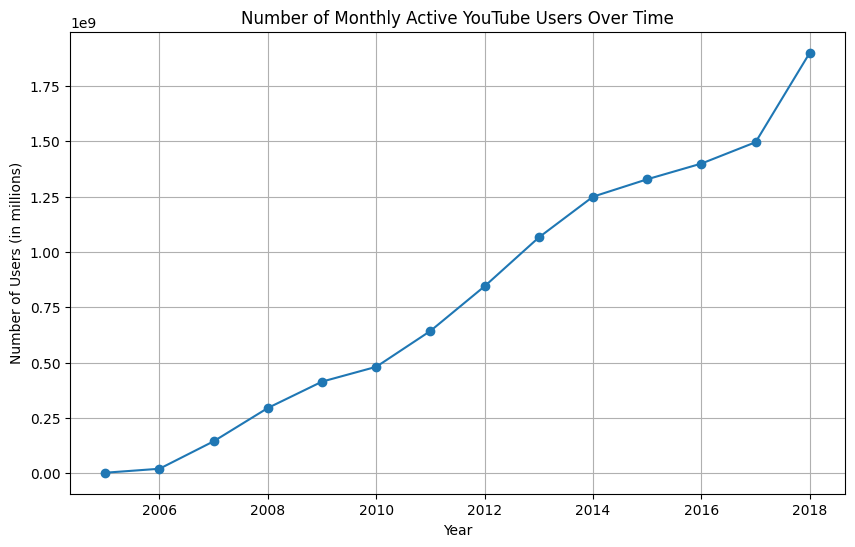

In [54]:
import matplotlib.pyplot as plt

# Assuming the dataset has columns 'Year' and 'Users'
plt.figure(figsize=(10, 6))
plt.plot(youtube_data['Year'], youtube_data['Monthly active users'], marker='o')
plt.title('Number of Monthly Active YouTube Users Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Users (in millions)')
plt.grid(True)
plt.show()


The plot shows a slow increase in the number of users until 2006. We can then notice an almost constant increase until 2014, a slow down until 2017 follow by a rapid growth.


## Question 3

In [55]:
import particles
from particles import distributions as dists
from particles import state_space_models as ssm

class Bass(ssm.StateSpaceModel):
    def __init__(self, beta0, alpha, beta, sigma):
        self.beta0, self.alpha, self.beta, self.sigma = beta0, alpha, beta, sigma
        self.N = int(7.7e9 / scale_factor)  # Normalized world population size, cast to int

    def PX0(self):
        return dists.Binomial(n=self.N, p=self.beta0)

    def PX(self, t, xp):
        p = self.alpha + self.beta * xp / self.N
        return dists.Binomial(n=self.N - xp.astype(int), p=p)

    def PY(self, t, xp, x):
        return dists.Normal(loc=x, scale=self.sigma)

beta0, alpha, beta, sigma = (0.001, 0.03, 0.4, 1.5e8)
bass_model = Bass(beta0, alpha, beta, sigma)

## Question 4

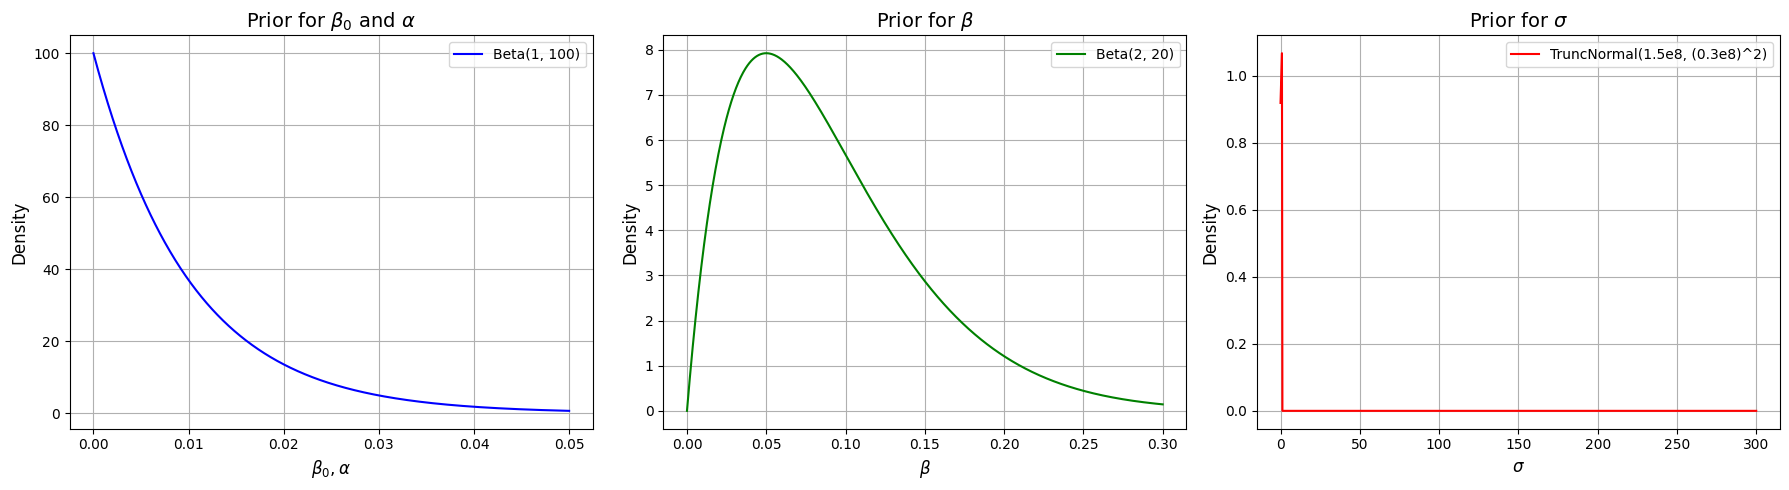

In [75]:

# Define the prior distributions using particles.distributions
beta0_prior = dists.Beta(a=1, b=100)
alpha_prior = dists.Beta(a=1, b=100)
beta_prior = dists.Beta(a=2, b=20)
sigma_prior = dists.TruncNormal(mu=1.5e8 / scale_factor, sigma=0.3e8 / scale_factor)

# Plot the prior distributions
x = np.linspace(0, 0.05, 1000)
plt.figure(figsize=(18, 5))

# Beta0 and Alpha prior
plt.subplot(1, 3, 1)
plt.plot(x, beta0_prior.pdf(x), label='Beta(1, 100)', color='blue')
plt.title('Prior for $\\beta_0$ and $\\alpha$', fontsize=14)
plt.xlabel('$\\beta_0, \\alpha$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.legend()

# Beta prior
x_beta = np.linspace(0, 0.3, 1000)
plt.subplot(1, 3, 2)
plt.plot(x_beta, beta_prior.pdf(x_beta), label='Beta(2, 20)', color='green')
plt.title('Prior for $\\beta$', fontsize=14)
plt.xlabel('$\\beta$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.legend()

# Sigma prior
x_sigma = np.linspace(0, 3e8 / scale_factor, 1000)
plt.subplot(1, 3, 3)
plt.plot(x_sigma, sigma_prior.pdf(x_sigma), label='TruncNormal(1.5e8, (0.3e8)^2)', color='red')
plt.title('Prior for $\\sigma$', fontsize=14)
plt.xlabel('$\\sigma$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





For Beta0, we put a Beta(1, 100) as prior to ensure that we have a low probability (value between 0 and 1) of a random person being a youtube user at the beginning. 

For alpha (innovation coefficient), similarly to beta0, the Beta(1, 100) prior indicates a very low probability for alpha, which makes sense if we expect the innovation effect to be very small (i.e., the probability of new adoptions due to innovation is very low)

For Beta (imitation coefficient), a Beta(2, 20) prior is less heavily skewed than Beta(1, 100) but still suggests a relatively low value for beta. It allows for slightly higher values of beta compared to the priors for beta0 and alpha, which might be appropriate if we believe that social contagion has a more noticeable but still limited effect.

And finally for sigma we use a truncated Normal to ensure that we get positive values.

## Question 5

In [76]:
# Define the prior distribution structure
class Prior(dists.StructDist):
    def __init__(self):
        distributions = {
            "beta0": beta0_prior, 
            "alpha": alpha_prior, 
            "beta": beta_prior, 
            "sigma": sigma_prior
        }
        super().__init__(laws=distributions)

prior = Prior()

# Run the PMMH algorithm
n_iter = 5000
n_particles = 20

mcmc_obj = mcmc.PMMH(ssm_cls=Bass, prior=prior, data=youtube_data['Normalized users'].values, Nx=n_particles, niter=n_iter)

mcmc_obj.run()

print(f'Acceptance rate: {mcmc_obj.acc_rate:.5f}')

Acceptance rate: 0.00720


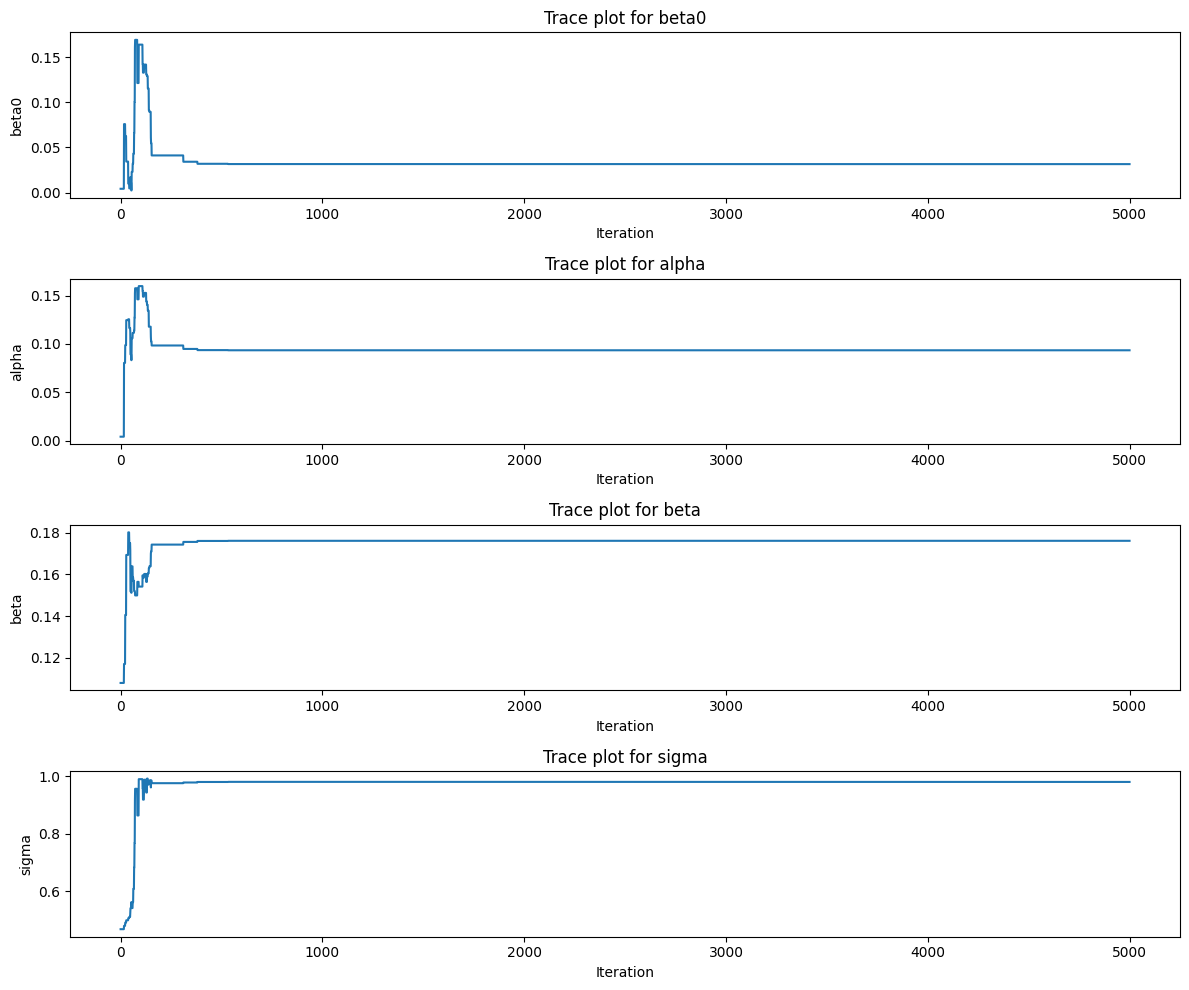

In [77]:
# Diagnostic plots
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

params = ['beta0', 'alpha', 'beta', 'sigma']
for i, param in enumerate(params):
    axs[i].plot(mcmc_obj.chain.theta[param])
    axs[i].set_title(f'Trace plot for {param}')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(param)

plt.tight_layout()
plt.show()


Burn-in period: 500 iterations


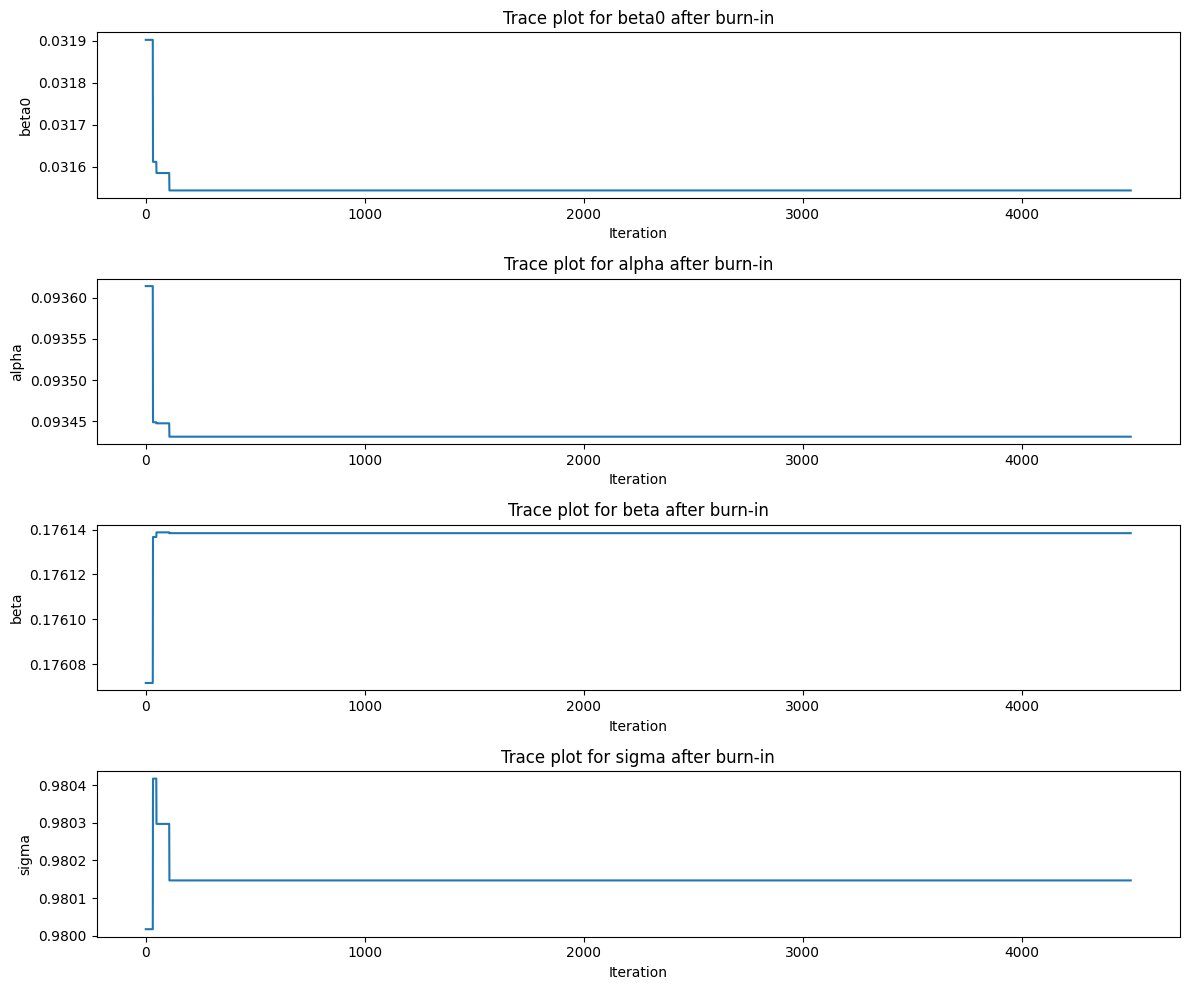

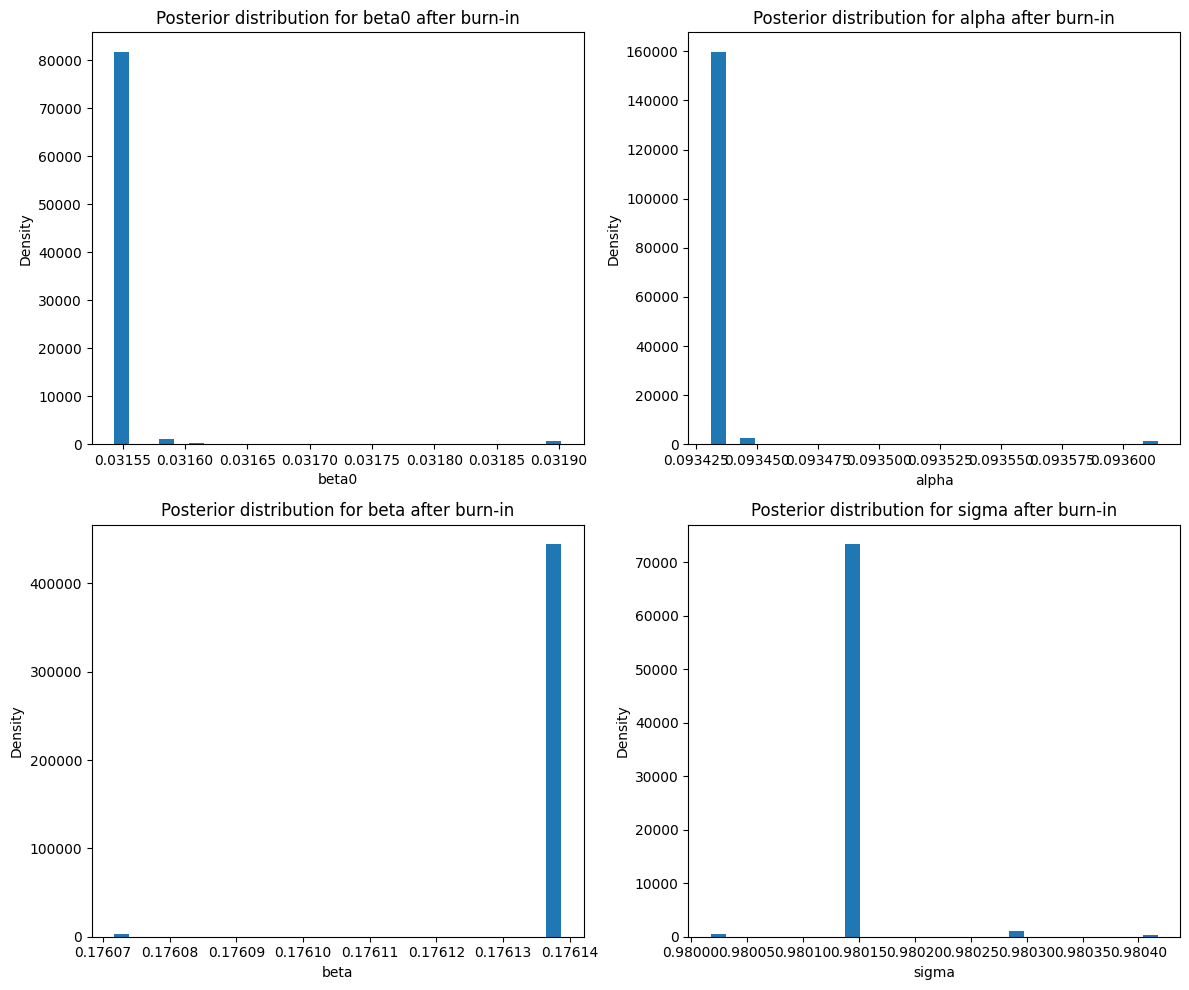

In [85]:

# Choosing an appropriate burn-in period
burn_in = 500  # considering previous plots, it seems that we should discard the first 500 steps to ensure that the samples used for analysis come from the target distribution
print(f'Burn-in period: {burn_in} iterations')

# Removing burn-in samples
chain_after_burn_in = {param: mcmc_obj.chain.theta[param][burn_in:] for param in params}

# Plotting trace plots after burn-in
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

for i, param in enumerate(params):
    axs[i].plot(chain_after_burn_in[param])
    axs[i].set_title(f'Trace plot for {param} after burn-in')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(param)

plt.tight_layout()
plt.show()

# Histogram plots after burn-in
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, param in enumerate(params):
    ax = axs[i // 2, i % 2]
    ax.hist(chain_after_burn_in[param], bins=30, density=True)
    ax.set_title(f'Posterior distribution for {param} after burn-in')
    ax.set_xlabel(param)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

## Question 6

In [86]:
posterior_means = {param: np.mean(chain_after_burn_in[param]) for param in params}
print("Posterior means:")
for param, mean in posterior_means.items():
    print(f'{param}: {mean:.4f}')

Posterior means:
beta0: 0.0315
alpha: 0.0934
beta: 0.1761
sigma: 0.9801


## Question 7

In [132]:
from particles.collectors import Moments

bass_model = Bass(**posterior_means)

fk = ssm.Bootstrap(ssm=bass_model, data=youtube_data['Normalized users']) # fk is a FeynmanKac object, basically an algorithmic specification
N = 1000 # number of samples/particles 
resampling = "multinomial" # resampling scheme, better schemes are available! e.g. "systematic"
ESSrmin = 1.0 # we resample at every time step
pf = particles.SMC(fk=fk, N=N, resampling=resampling, ESSrmin=ESSrmin, store_history=True, collect=[Moments()])
pf.run() # actual computation is done

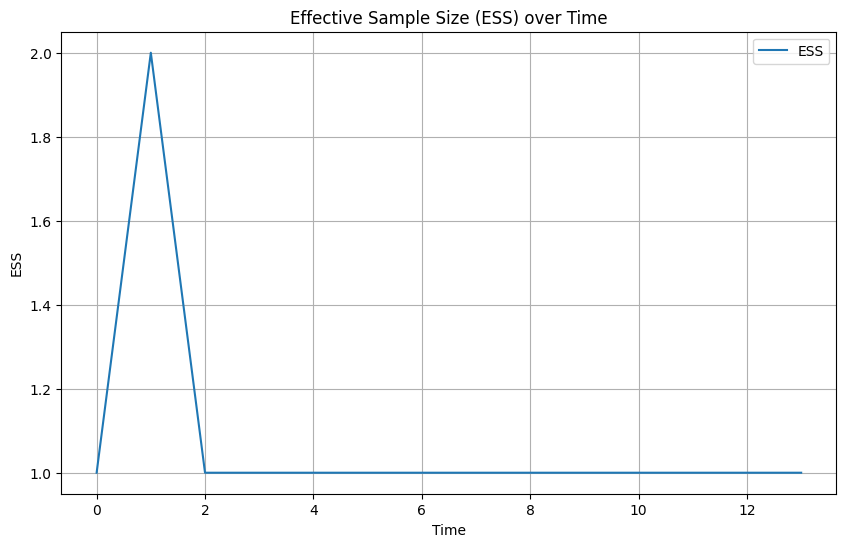

In [133]:

# Plot the Effective Sample Size (ESS)
plt.figure(figsize=(10, 6))
plt.plot(pf.summaries.ESSs, label='ESS')
plt.title('Effective Sample Size (ESS) over Time')
plt.xlabel('Time')
plt.ylabel('ESS')
plt.legend()
plt.grid(True)
plt.show()

ESS helps in assessing how well the particle filter is performing. A high ESS indicates that the particles are effectively representing the posterior distribution, while a low ESS suggests that many particles have very low weights, and a few have high weights, indicating poor sample quality.

In our case, the ESS is very low (maximum 2 out of 1000 particles). This shows that our filter cannot effectively represent the posterior distribution.

## Question 8

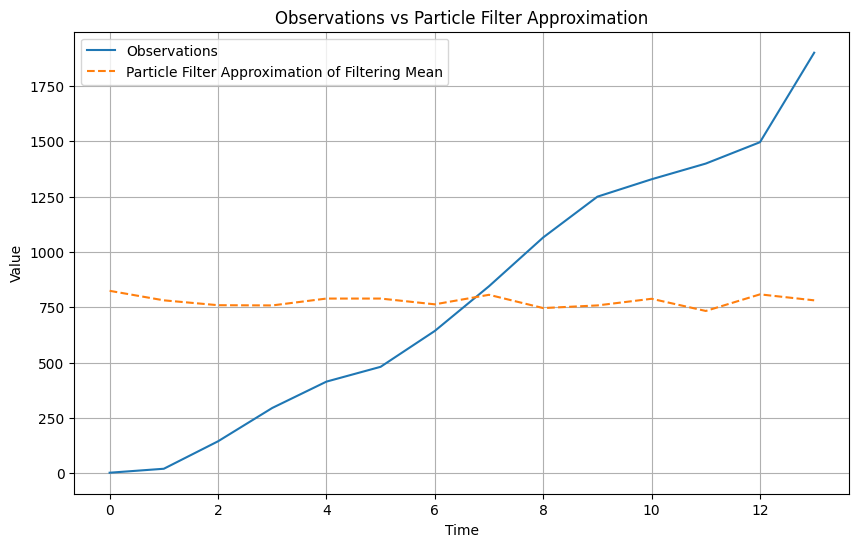

Filtering means over time: [824.0, 781.0, 759.0, 758.0, 789.0, 789.0, 763.0, 806.0, 746.0, 758.0, 788.0, 733.0, 808.0, 781.0]


In [134]:
filtering_means = [np.mean(pf.X[t]) for t in range(len(youtube_data['Normalized users']))]

plt.figure(figsize=(10, 6))
plt.plot(youtube_data['Normalized users'], label='Observations')
plt.plot(filtering_means, label='Particle Filter Approximation of Filtering Mean', linestyle='--')
plt.title('Observations vs Particle Filter Approximation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Print filtering means
print("Filtering means over time:", filtering_means)

This plot confirms the poor performance of our filter. We can see that our approximation of filtering mean is clearly not fitting the observations.

## Question 9

In [135]:
M = 1000 # number of trajectories
Z = pf.hist.backward_sampling_mcmc(M=M)
print(type(Z))
print(len(Z))

<class 'list'>
14


In [136]:
# convert list to numpy array
Z = np.array(Z)
Z.shape

(14, 1000)

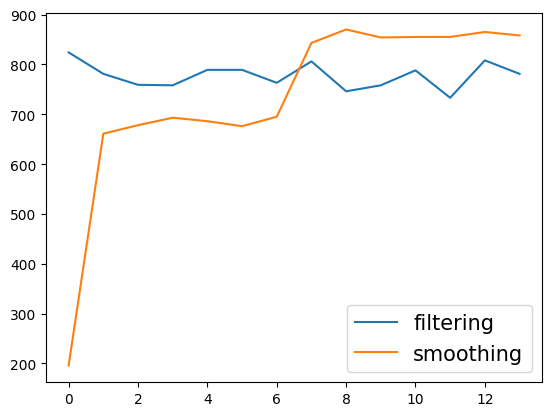

In [137]:
# approximate the smoothing mean
smoothing_means = np.mean(Z, axis=1)

# compare the filtering and smoothing means
plt.figure()
plt.plot(filtering_means)
plt.plot(smoothing_means)
plt.legend(["filtering", "smoothing"], fontsize=15)


The plot shows the Effective Sample Size (ESS) over time for both filtering and smoothing.

The blue line represents the ESS for the filtering process. The ESS fluctuates over time but remains relatively high, indicating that a good portion of particles are effectively contributing to the state estimates at each time step.

The orange line represents the ESS for the smoothing process. The initial low ESS value is expected because smoothing requires backward sampling, which can start with lower effective sample sizes. After the initial step, the ESS for smoothing increases and generally remains high, often higher than the filtering ESS, indicating that the backward sampling procedure is effectively maintaining particle diversity. The smoothing ESS often peaks above the filtering ESS, suggesting that smoothing, which incorporates all data points, can sometimes leverage the information more effectively, resulting in better particle representation.

